### configurer l'augmentation de la mémoire sur GPU

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)


### configurer le traitement de données sur GPU

In [2]:
import keras
import tensorflow as tf

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

### les importations néccessaires 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Conv2D,Dense,Flatten,MaxPool2D,Dropout
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


#### affecter la valeur "True" dans LOAD_TRUNCATED_IMAGES pour ne pas se bloquer dans les images erronées

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### definition de la fonctio qui permet d'importer les parties de la base de données 

In [5]:
def import_dataset(path,img_size):
    '''
    import_dataset permet d'importer une base de données à partir d'un path donné
    
    input :
    path  -- de type string -- le chemain de la base de données dans le disque
    
    output :
    dataset -- de type Imagegenerator -- la base de données qui contient 
                                         n classes avec leurs labels
    img_size -- tuple dim=2 -- le dimension des images                                     
    '''
    

    dataset = ImageDataGenerator(rescale=1./255) \
        .flow_from_directory(
                    directory=path, 
                    target_size=img_size,
                    shuffle=True,
                    batch_size=32,
        )
    return dataset

### importation de la base de données : train, valid, test

In [6]:
path_train='C:/stage_data_inception/data collection/final dataset/train'
path_valid='C:/stage_data_inception/data collection/final dataset/valid'
path_test='C:/stage_data_inception/data collection/final dataset/test'

size=(224,224)

train_batches= import_dataset(path_train,size)
valid_batches= import_dataset(path_valid,size)
test_batches= import_dataset(path_test,size)



Found 22535 images belonging to 2 classes.
Found 2450 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Cette fonction affiche la matrice de confusion.
    
    Elle est disponible integralement dans la documentation officielle de sckitlearn
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# transfer learning du fameux modèle Inception :

######  Inception v3 est un réseau de neurones convolutifs destiné à l'analyse d'images et à la détection d'objets, et a débuté comme module pour Googlenet. Il s'agit de la troisième édition du réseau de neurones convolutifs Inception de Google, initialement présenté lors du défi de reconnaissance ImageNet. Tout comme ImageNet peut être considéré comme une base de données d'objets visuels classés, Inception aide à la classification d'objets [2] dans le monde de la vision par ordinateur. Le nom original (Inception) a reçu ce nom de code après qu'un mème internet populaire "'we need to go deeper'" est devenu viral, citant une phrase du film Inception de Christopher Nolan.

source : https://en.wikipedia.org/wiki/Inceptionv3

#### importation du modèle et faire quelques modifications 

In [37]:
# importation du modèle qui se trouve déjà dans le framework keras 
from tensorflow.keras.applications.inception_v3 import InceptionV3
model_incep = InceptionV3(
        input_shape = (224, 224, 3),  # dimension de l'entré du modèle
        include_top = False,          # ne pas inclure la derniere couche lors de l'importation du modèle
        weights = 'imagenet')         # utiliser les valeurs de parametres issuent de l'entrainement sur la fameuse imagenet dataset

# ne pas changer les valeurs de parametres à l'entrainement du modèle
for layer in model_incep.layers:
    layer.trainable=False
    
# ajouter quelques couche dans le queue du modèle     
X=Flatten()(model_incep.output) 
X=Dense(units=1024,activation='relu')(X)
X=Dropout(0.2)(X)
X=Dense(units=2,activation='softmax')(X)

# défnir le point d'entré et de sortie du modèle
model_inception=tf.keras.Model(inputs=model_incep.input,outputs=X)

# affichage de tout les couches de modèle
model_inception.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

#### compilation, entrainement et prédiction

In [38]:
# compiler le modèle
model_inception.compile(
        optimizer=Adam(learning_rate=0.0001),   # l'otimisateur utilisé avec son taux d'apprentissage
        loss='binary_crossentropy',             # la fonction de perte utilisé
        metrics=['accuracy','AUC'])             # les métriques à afficher lors de l'entrainement

#entrainer le modèle
model_inception.fit(
        x=train_batches,                        # les données d'entrainement
        steps_per_epoch=len(train_batches),     # le nombre de pas par époche pour l'entrainement
        validation_data=valid_batches,          # les données de validation
        validation_steps=len(valid_batches),    # le nombre de pas par époche pour la validation
        epochs=4,                               # le nombre d'époches
        verbose=1,                              # la méthode d'affichage lors de l'entrainement
        shuffle=True                            # mélanger aléatoirement les données 
)

# la prédiction
prediction_inception=model_inception.predict(
        x=test_batches,                         # les données de test
        steps=len(test_batches),                # nombre de pas pas époche
        verbose=1)                              # la méthode d'affichage lors de test 


Epoch 1/4
169/705 [======>.......................] - ETA: 1:51 - loss: 0.8879 - accuracy: 0.6267 - auc: 0.6695

A:\anacondaa\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


705/705 [==============================] - 197s 269ms/step - loss: 0.6804 - accuracy: 0.6396 - auc: 0.7020 - val_loss: 0.8166 - val_accuracy: 0.6229 - val_auc: 0.6856
Epoch 2/4
705/705 [==============================] - 287s 406ms/step - loss: 0.5730 - accuracy: 0.6820 - auc: 0.7633 - val_loss: 0.6771 - val_accuracy: 0.6514 - val_auc: 0.6948
Epoch 3/4
705/705 [==============================] - 267s 379ms/step - loss: 0.5369 - accuracy: 0.7139 - auc: 0.7993 - val_loss: 0.7585 - val_accuracy: 0.6539 - val_auc: 0.6952
Epoch 4/4
110/110 [==============================] - 29s 249ms/step


#### enregistrement du modèle

In [ ]:
tf.keras.models.save_model(model_inception,filepath="C:\stage_data_inception\code\inception.hdf5")

#### tester les performances du modèle

f1 score= 0.43338788870703765 et auc score = 0.4974166666666667 
 

Confusion matrix, without normalization
[[1107  893]
 [ 838  662]]


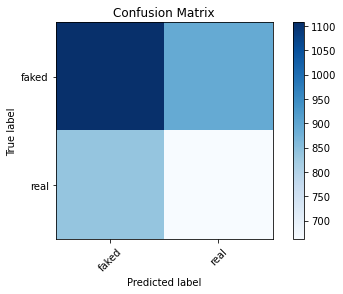

In [46]:
# calcul de AUC
auc_score=sklearn.metrics.roc_auc_score(
    y_true=test_batches.classes,                         # les classes réelles  
    y_score=np.argmax(prediction_inception, axis=-1))    # les classes prédictées  

# calcul de f1_score
f1_score=sklearn.metrics.f1_score(                   
    y_true=test_batches.classes,                         # les classes réelles
    y_pred=np.argmax(prediction_inception, axis=-1))               # les classes prédictées 

print("f1 score= {} et auc score = {} \n \n".format(f1_score,auc_score)) 

# la matrice de confusion 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction_inception, axis=-1))
cm_plot_labels = ['faked','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# transfer learning du fameux modèle VGG16 :

######  VGG16 est un modèle de réseau neuronal convolutif proposé par K. Simonyan et A. Zisserman de l'Université d'Oxford dans l'article "Very Deep Convolutional Networks for Large-Scale Image Recognition". Le modèle atteint une précision de 92,7 % dans le test top-5 d'ImageNet, qui est un ensemble de données de plus de 14 millions d'images appartenant à 1000 classes. VGG16 a été entraîné pendant des semaines et a utilisé des GPU NVIDIA Titan Black.

source : https://neurohive.io/en/popular-networks/vgg16/

#### importation du modèle et faire quelques modifications 

In [8]:
VGG_input = Input(shape=(224, 224, 3))
# importation du modèle qui se trouve déjà dans le framework keras 
model_VGG =tf.keras.applications.vgg16.VGG16(
        include_top=False,        # ne pas inclure la derniere couche lors de l'importation du modèle
        weights='imagenet',       # utiliser les valeurs de parametres issuent de l'entrainement sur la fameuse imagenet dataset
        input_tensor=VGG_input    # dimension de l'entré du modèle
)

# ne pas changer les valeurs de parametres à l'entrainement du modèle
for layer in model_VGG.layers[:-6]:
    layer.trainable=False
    
# ajouter quelques couche dans le queue du modèle         
X=Flatten()(model_VGG.output)
X=Dense(units=128,activation='relu')(X)
X=Dropout(0.2)(X)
X=Dense(units=2,activation='softmax')(X)

# défnir le point d'entré et de sortie du modèle
model_VGG=tf.keras.Model(inputs=model_VGG.input,outputs=X)

# affichage de tout les couches de modèle
model_VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### compilation, entrainement et prédiction

In [9]:
# compiler le modèle
model_VGG.compile(
        optimizer=RMSprop(learning_rate=0.00001),   # l'otimisateur utilisé avec son taux d'apprentissage
        loss='binary_crossentropy',             # la fonction de perte utilisé
        metrics=['accuracy','AUC'])             # les métriques à afficher lors de l'entrainement

#entrainer le modèle
model_VGG.fit(
        x=train_batches,                        # les données d'entrainement
        steps_per_epoch=len(train_batches),     # le nombre de pas par époche pour l'entrainement
        validation_data=valid_batches,          # les données de validation
        validation_steps=len(valid_batches),    # le nombre de pas par époche pour la validation
        epochs=6,                               # le nombre d'époches
        verbose=1,                              # la méthode d'affichage lors de l'entrainement
        shuffle=True                            # mélanger aléatoirement les données 
)

# la prédiction
prediction_VGG=model_VGG.predict(
        x=test_batches,                         # les données de test
        steps=len(test_batches),                # nombre de pas pas époche
        verbose=1                               # la méthode d'affichage lors de test 
)


Epoch 1/6
103/705 [===>..........................] - ETA: 10:37 - loss: 0.6648 - accuracy: 0.6104 - auc: 0.6502

A:\anacondaa\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


705/705 [==============================] - 890s 1s/step - loss: 0.6097 - accuracy: 0.6465 - auc: 0.7180 - val_loss: 0.6703 - val_accuracy: 0.6282 - val_auc: 0.6867
Epoch 2/6
705/705 [==============================] - 553s 785ms/step - loss: 0.5566 - accuracy: 0.6928 - auc: 0.7782 - val_loss: 0.7243 - val_accuracy: 0.6392 - val_auc: 0.6952
Epoch 3/6
705/705 [==============================] - 498s 707ms/step - loss: 0.5137 - accuracy: 0.7382 - auc: 0.8228 - val_loss: 0.7089 - val_accuracy: 0.6522 - val_auc: 0.7002
Epoch 4/6
705/705 [==============================] - 304s 431ms/step - loss: 0.4667 - accuracy: 0.7765 - auc: 0.8627 - val_loss: 0.6925 - val_accuracy: 0.6539 - val_auc: 0.7027
Epoch 5/6
705/705 [==============================] - 309s 437ms/step - loss: 0.4106 - accuracy: 0.8168 - auc: 0.8997 - val_loss: 0.7118 - val_accuracy: 0.6551 - val_auc: 0.7043
Epoch 6/6
110/110 [==============================] - 75s 684ms/step


In [ ]:
tf.keras.models.save_model(model_VGG,filepath="C:\stage_data_inception\code\VGG16.hdf5")

#### tester les performances du modèle

f1 score= 0.4821479577263639 et auc score = 0.4920833333333333
Confusion matrix, without normalization
[[ 843 1157]
 [ 656  844]]


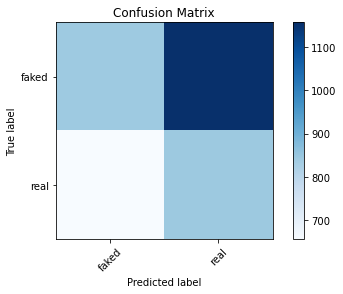

In [11]:
# calcul de AUC
auc_score=sklearn.metrics.roc_auc_score(
    y_true=test_batches.classes,                         # les classes réelles  
    y_score=np.argmax(prediction_VGG, axis=-1))    # les classes prédictées  

# calcul de f1_score
f1_score=sklearn.metrics.f1_score(                   
    y_true=test_batches.classes,                         # les classes réelles
    y_pred=np.argmax(prediction_VGG, axis=-1))               # les classes prédictées 

print("f1 score= {} et auc score = {}".format(f1_score,auc_score)) 

# la matrice de confusion 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction_VGG, axis=-1))
cm_plot_labels = ['faked','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [9]:
input_1=Input(shape=(224,224,3))
layer1=Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same')(input_1)
layer2=MaxPool2D(pool_size=(2, 2), strides=2)(layer1)
layer3=Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same')(layer2)
layer4=MaxPool2D(pool_size=(2, 2), strides=2)(layer3)
layer5=Dropout(0.1)(layer4)
layer6=Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same')(layer5)
layer7=Flatten()(layer6)
Denselayer1=Dense(units=64,activation='relu')(layer7)
Denselayer2=Dense(units=64,activation='relu')(Denselayer1)
layer8=Dropout(0.1)(Denselayer2)
layer9=Dense(units=2, activation='softmax')(layer8)
model_2=tf.keras.Model(inputs=input_1,outputs=layer9)

In [11]:
# compiler le modèle
model_2.compile(
        optimizer=RMSprop(learning_rate=0.0001),   # l'otimisateur utilisé avec son taux d'apprentissage
        loss='binary_crossentropy',             # la fonction de perte utilisé
        metrics=['accuracy','AUC'])             # les métriques à afficher lors de l'entrainement

#entrainer le modèle
model_2.fit(
        x=train_batches,                        # les données d'entrainement
        steps_per_epoch=len(train_batches),     # le nombre de pas par époche pour l'entrainement
        validation_data=valid_batches,          # les données de validation
        validation_steps=len(valid_batches),    # le nombre de pas par époche pour la validation
        epochs=3,                               # le nombre d'époches
        verbose=1,                              # la méthode d'affichage lors de l'entrainement
        shuffle=True                            # mélanger aléatoirement les données 
)

# la prédiction
prediction_mod_2=model_2.predict(
        x=test_batches,                         # les données de test
        steps=len(test_batches),                # nombre de pas pas époche
        verbose=1                               # la méthode d'affichage lors de test 
)


Epoch 1/3
705/705 [==============================] - 476s 673ms/step - loss: 0.5583 - accuracy: 0.7018 - auc: 0.7822 - val_loss: 0.7065 - val_accuracy: 0.6176 - val_auc: 0.6615
Epoch 2/3
705/705 [==============================] - 256s 364ms/step - loss: 0.5389 - accuracy: 0.7224 - auc: 0.8048 - val_loss: 0.7296 - val_accuracy: 0.6224 - val_auc: 0.6601
Epoch 3/3
110/110 [==============================] - 80s 733ms/step


In [12]:
tf.keras.models.save_model(model_2,filepath="C:\stage_data_inception\code\model_intern.hdf5")

f1 score= 0.4050367261280167 et auc score = 0.49800000000000005
Confusion matrix, without normalization
[[1220  780]
 [ 921  579]]


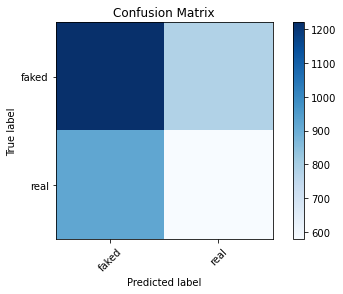

In [13]:
# calcul de AUC
auc_score=sklearn.metrics.roc_auc_score(
    y_true=test_batches.classes,                         # les classes réelles  
    y_score=np.argmax(prediction_mod_2, axis=-1))    # les classes prédictées  

# calcul de f1_score
f1_score=sklearn.metrics.f1_score(                   
    y_true=test_batches.classes,                         # les classes réelles
    y_pred=np.argmax(prediction_mod_2, axis=-1))               # les classes prédictées 

print("f1 score= {} et auc score = {}".format(f1_score,auc_score)) 

# la matrice de confusion 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction_mod_2, axis=-1))
cm_plot_labels = ['faked','real']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [8]:
model_5 = tf.keras.models.load_model("C:\stage_data_inception\code\my_model_0-51.hdf5")